**Step 1: Determine time series period and forecast period + Data transformation**

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
start_date = "2021-11-17"
end_date = "2023-11-17"  
price_data = yf.download('USDPLN=X', start_date, end_date)
price_data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-17,4.110564,4.123340,4.102319,4.109285,4.109285,0
2021-11-18,4.117276,4.119165,4.098500,4.116634,4.116634,0
2021-11-19,4.105336,4.161900,4.100819,4.104927,4.104927,0
2021-11-22,4.152873,4.186960,4.149506,4.153800,4.153800,0
2021-11-23,4.185400,4.199850,4.171068,4.184500,4.184500,0
...,...,...,...,...,...,...
2023-11-10,4.152620,4.161270,4.128500,4.152620,4.152620,0
2023-11-13,4.135206,4.153610,4.130365,4.135206,4.135206,0
2023-11-14,4.133700,4.142350,4.048945,4.133700,4.133700,0


**Data Transformation**

In [2]:
data=price_data.copy()

In [3]:
data.index=pd.to_datetime(data.index)
data=data.asfreq('b')
data=data.fillna(method='ffill')

In [4]:
data=data.drop(['Open','High','Low','Close','Volume'],axis=1)
data

,Adj Close
Date,
2021-11-17,4.109285
2021-11-18,4.116634
2021-11-19,4.104927
2021-11-22,4.153800
2021-11-23,4.184500
...,...
2023-11-10,4.152620
2023-11-13,4.135206
2023-11-14,4.133700


Observe the time series to get an overiew

<Axes: title={'center': 'PLNUSD price'}, xlabel='Date'>

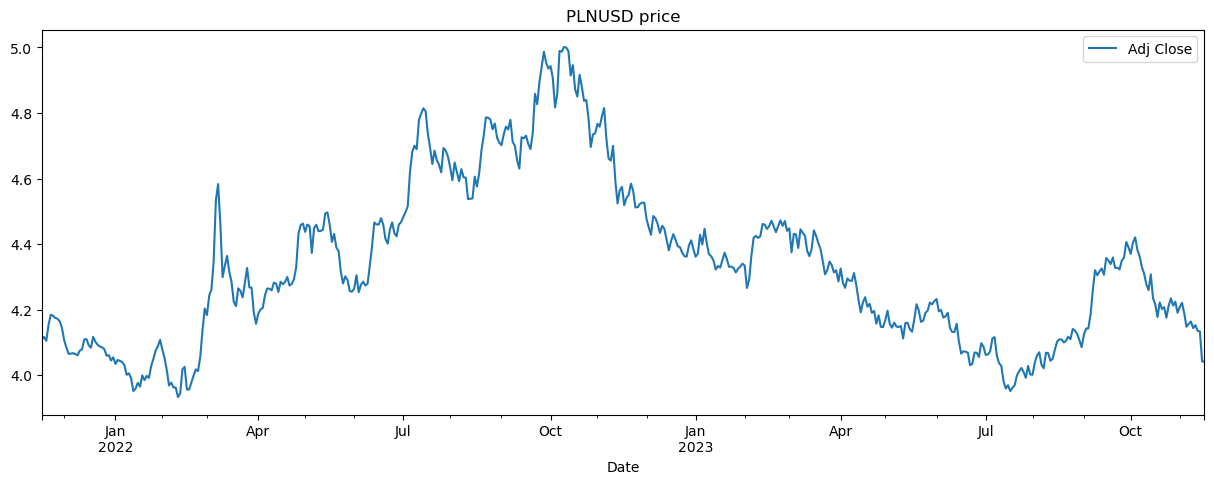

In [5]:
data.plot(figsize=(15,5), title="PLNUSD price")

<Axes: title={'center': 'Moving Average PLNUSD'}, xlabel='Date'>

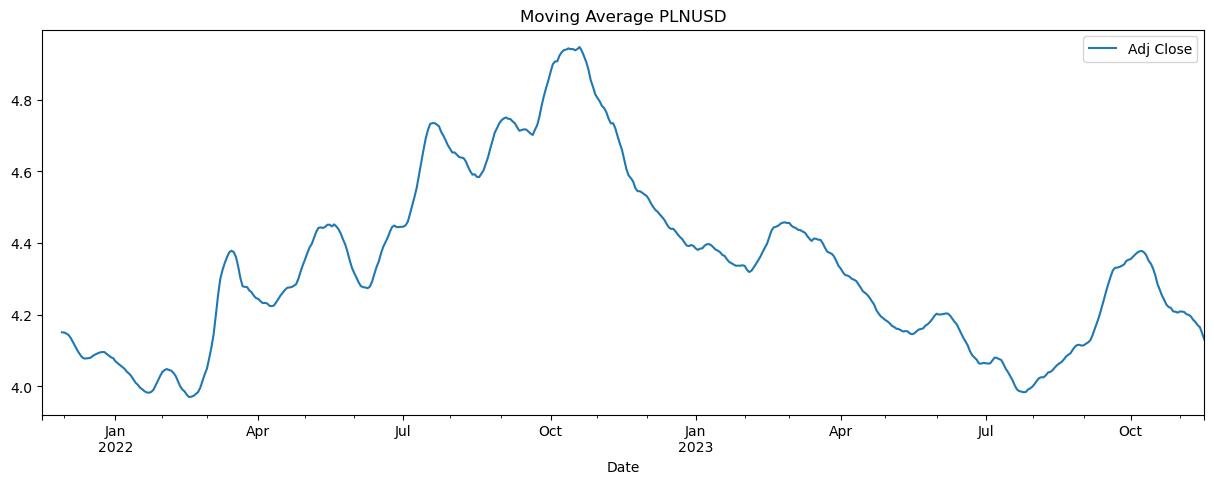

In [6]:
#Smoothing time series using moving average 
data_ma = data.rolling(10).mean()
data_ma.plot(figsize=(15,5), title ='Moving Average PLNUSD')

**Step 2:
Decomposing time series to see trends and seasonality needed to include in model**

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

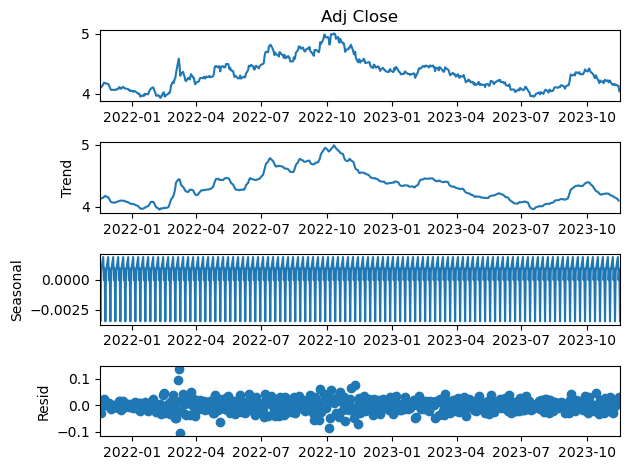

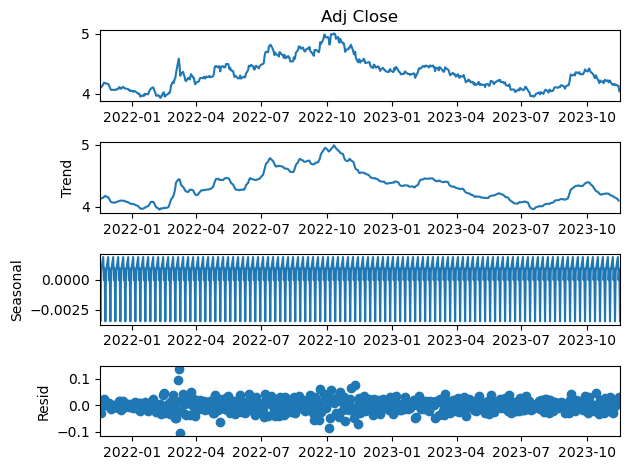

In [8]:
decom_data= seasonal_decompose(data['Adj Close'],model='additive')
decom_data.plot()

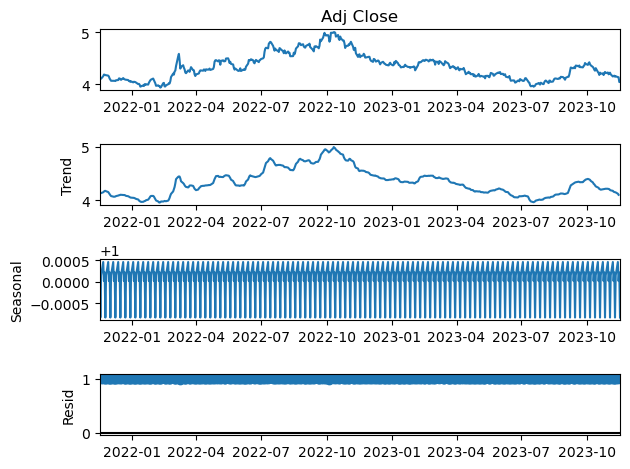

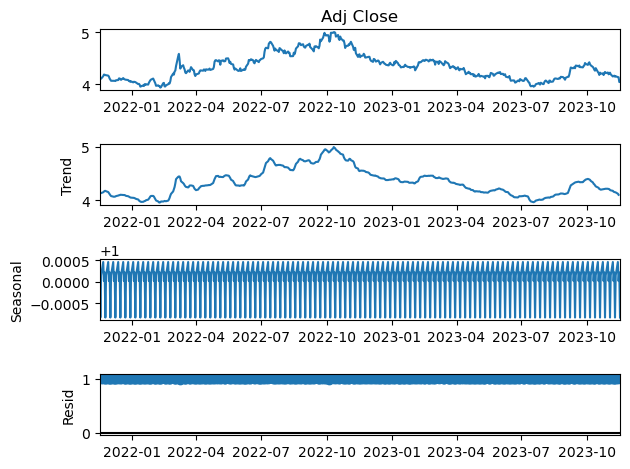

In [9]:
# What about multiplicative?
decom_data=seasonal_decompose(data['Adj Close'], model='multiplicative')
decom_data.plot()

From additive model and multiplicative model, we could observe there is:
1. A high frequency of seasonality.
2. In additive decomposing, residual isn't constant.
3. In multiplicative decomposing, residual is constant.

*I'm not sure the meaning of the differnce of residual in both decomposing

We can make sure there is seasonality we should included in our model. (Might use SARIMAX)

**Step 3: To see if time series data is stationary and what about higher orders?**

In [10]:
import statsmodels.tsa.stattools as sts

In [11]:
sts.adfuller(data)

(-1.6539303132094303,
 0.4549914643409661,
 4,
 517,
 {'1%': -3.443061925077973,
  '5%': -2.8671466525252014,
  '10%': -2.5697561378507907},
 -1916.1191131799742)

In [12]:
#Higher orders:
data['sp_change']=data.pct_change()  #sp_change stands for spot rate change
data

,Adj Close,sp_change
Date,,
2021-11-17,4.109285,NaN
2021-11-18,4.116634,0.001788
2021-11-19,4.104927,-0.002844
2021-11-22,4.153800,0.011906
2021-11-23,4.184500,0.007391
...,...,...
2023-11-10,4.152620,0.002177
2023-11-13,4.135206,-0.004193
2023-11-14,4.133700,-0.000364


In [13]:
data2=data.dropna()
data2

,Adj Close,sp_change
Date,,
2021-11-18,4.116634,0.001788
2021-11-19,4.104927,-0.002844
2021-11-22,4.153800,0.011906
2021-11-23,4.184500,0.007391
2021-11-24,4.181443,-0.000731
...,...,...
2023-11-10,4.152620,0.002177
2023-11-13,4.135206,-0.004193
2023-11-14,4.133700,-0.000364


In [14]:
sts.adfuller(data2.sp_change)

(-17.032435903308393,
 8.30673644396418e-30,
 1,
 519,
 {'1%': -3.4430126933746767,
  '5%': -2.8671249839002764,
  '10%': -2.569744590233924},
 -3400.3877373050395)

The reuslts indicat that using the percentage change (first diff order) to build model since it is stationary

**Step 4 : Determine which model should we try first.**
**Given that there is a seasonality and first order of difference is stationary, we start from ARIMA then SARIMAX** 

Text(0.5, 1.0, 'ACF for spot_change')

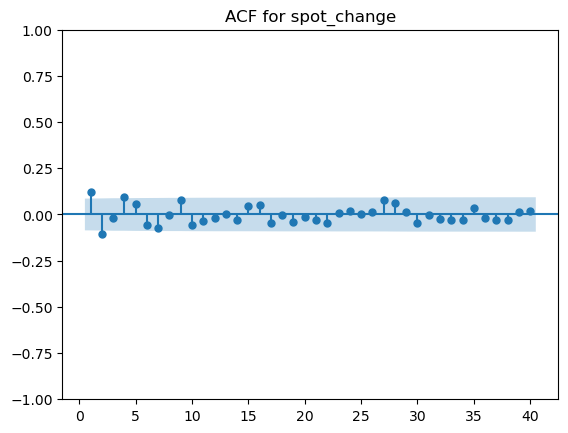

In [15]:
#Guess of lags 
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(data2.sp_change, zero=False, lags=40)
plt.title("ACF for spot_change")

Text(0.5, 1.0, 'PACF for spot_change')

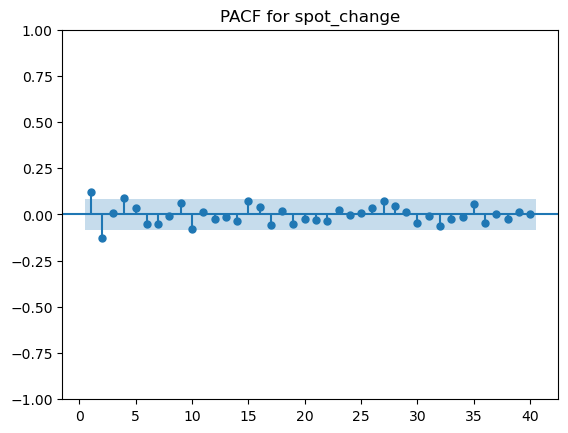

In [16]:
sgt.plot_pacf(data2.sp_change,zero=False,lags=40,method='ols')
plt.title("PACF for spot_change")

Based on the spot change % ACF and PACF result, I believe that the ARIMA (5,1,5) on orignal spot rate might be a great model, lets try!

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
data.head()

,Adj Close,sp_change
Date,,
2021-11-17,4.109285,NaN
2021-11-18,4.116634,0.001788
2021-11-19,4.104927,-0.002844
2021-11-22,4.153800,0.011906
2021-11-23,4.184500,0.007391


In [19]:
model_data_arima_515=ARIMA(data['Adj Close'], order=(5,1,5))
results_data_arima_515=model_data_arima_515.fit()
results_data_arima_515.summary()
#Since the coefficient weren't significant, we reduce the order of AR and MA

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  522
Model:                 ARIMA(5, 1, 5)   Log Likelihood                1009.699
Date:                Mon, 20 Nov 2023   AIC                          -1997.397
Time:                        12:17:52   BIC                          -1950.584
Sample:                    11-17-2021   HQIC                         -1979.060
                         - 11-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2657      2.089     -0.127      0.899      -4.360       3.829
ar.L2         -0.2471      0.573     -0.431      0.666      -1.371       0.877
ar.L3         -0.5184      0.420     -1.234      0.217      -1.342       0.305
ar.L4          0.2005      0.885      0.227      0.821      -1.534       1.935
ar.L5         -0.1180      0.844     -0.140      0.889      -1.773       1.537
ma.L1          0.4063      2.091      0.194      0.846      -3.692       4.504
ma.L2          0.1846      0.812      0.227      0.820      -1.406       1.775
ma.L3          0.5196      0.435      1.194      0.232      -0.333       1.372
ma.L4         -0.0854      0.871     -0.098      0.922      -1.793       1.622
ma.L5          0.1365      0.630      0.217      0.829      -1.099       1.372
sigma2         0.0012   5.85e-05     20.747      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               103.36
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
model_data_arima_313=ARIMA(data['Adj Close'], order=(3,1,3))
results_data_arima_313=model_data_arima_313.fit()
results_data_arima_313.summary()

C:\Users\mike6\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  522
Model:                 ARIMA(3, 1, 3)   Log Likelihood                1005.912
Date:                Mon, 20 Nov 2023   AIC                          -1997.825
Time:                        12:17:53   BIC                          -1968.035
Sample:                    11-17-2021   HQIC                         -1986.156
                         - 11-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4569      0.440      1.037      0.300      -0.406       1.320
ar.L2         -0.8994      0.120     -7.524      0.000      -1.134      -0.665
ar.L3          0.1156      0.382      0.302      0.762      -0.634       0.865
ma.L1         -0.3436      0.443     -0.776      0.438      -1.212       0.524
ma.L2          0.7881      0.117      6.716      0.000       0.558       1.018
ma.L3         -0.0094      0.365     -0.026      0.979      -0.724       0.705
sigma2         0.0012   5.74e-05     20.986      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               135.43
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
model_data_arima_213=ARIMA(data['Adj Close'], order=(2,1,3))
results_data_arima_213=model_data_arima_213.fit()
results_data_arima_213.summary()
# I ultimately find our the ARIMA(2,1,2) model has coefficient there were significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  522
Model:                 ARIMA(2, 1, 3)   Log Likelihood                1006.988
Date:                Mon, 20 Nov 2023   AIC                          -2001.977
Time:                        12:17:55   BIC                          -1976.442
Sample:                    11-17-2021   HQIC                         -1991.975
                         - 11-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4397      0.151      2.916      0.004       0.144       0.735
ar.L2         -0.7482      0.145     -5.166      0.000      -1.032      -0.464
ma.L1         -0.3139      0.153     -2.046      0.041      -0.615      -0.013
ma.L2          0.5882      0.158      3.729      0.000       0.279       0.897
ma.L3          0.1297      0.052      2.503      0.012       0.028       0.231
sigma2         0.0012   5.89e-05     20.830      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               114.93
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
model_data_arima_312=ARIMA(data['Adj Close'], order=(3,1,2))
results_data_arima_312=model_data_arima_312.fit()
results_data_arima_312.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  522
Model:                 ARIMA(3, 1, 2)   Log Likelihood                1007.190
Date:                Mon, 20 Nov 2023   AIC                          -2002.380
Time:                        12:17:56   BIC                          -1976.846
Sample:                    11-17-2021   HQIC                         -1992.378
                         - 11-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5793      0.183      3.159      0.002       0.220       0.939
ar.L2         -0.7958      0.144     -5.518      0.000      -1.078      -0.513
ar.L3          0.1428      0.053      2.683      0.007       0.038       0.247
ma.L1         -0.4499      0.179     -2.519      0.012      -0.800      -0.100
ma.L2          0.6266      0.156      4.020      0.000       0.321       0.932
sigma2         0.0012   5.87e-05     20.860      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               118.55
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
model_data_arima_212=ARIMA(data['Adj Close'], order=(2,1,2))
results_data_arima_212=model_data_arima_212.fit()
results_data_arima_212.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  522
Model:                 ARIMA(2, 1, 2)   Log Likelihood                1006.298
Date:                Mon, 20 Nov 2023   AIC                          -2002.596
Time:                        12:17:57   BIC                          -1981.317
Sample:                    11-17-2021   HQIC                         -1994.261
                         - 11-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0109      0.127      0.086      0.931      -0.237       0.259
ar.L2         -0.7330      0.116     -6.345      0.000      -0.959      -0.507
ma.L1          0.0926      0.135      0.686      0.493      -0.172       0.357
ma.L2          0.6451      0.131      4.932      0.000       0.389       0.902
sigma2         0.0012   5.72e-05     21.507      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               120.78
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looks like ARIMA (3,1,2) has the highest likelihood and lowest IC loss

Likelihood test

In [24]:
from scipy.stats.distributions import chi2
def LLR_test(model1, model2, DF=1):
    L1=model1.fit().llf
    L2=model2.fit().llf
    LR=-2*(L1-L2)
    p=chi2.sf(LR, DF).round(3) #Chi2 Survival function (1 - `cdf`)
    return p

In [25]:
LLR_test(model_data_arima_312,model_data_arima_515)
#ASK

0.025

Residual stationary check

In [26]:
data['res_arima_312']=results_data_arima_312.resid
sts.adfuller(data['res_arima_312'])

(-119.04236946241906,
 0.0,
 0,
 521,
 {'1%': -3.4429638415440995,
  '5%': -2.867103482127635,
  '10%': -2.569733131582922},
 -1923.8803456501482)

Residual stationary provided sound accurate for this model,and it proved that there's stationary on residuals.

The question will be: should I incorporate seasonality into this model? Should we use the same order of ARIMA and move towards SARIMAX

In [27]:
#pip install pmdarima
#import pmdarima as pm

In [28]:
#data

,Adj Close,sp_change,res_arima_312
Date,,,
2021-11-17,4.109285,NaN,4.109285
2021-11-18,4.116634,0.001788,0.007349
2021-11-19,4.104927,-0.002844,-0.012566
2021-11-22,4.153800,0.011906,0.051341
2021-11-23,4.184500,0.007391,0.022556
...,...,...,...
2023-11-10,4.152620,0.002177,0.018215
2023-11-13,4.135206,-0.004193,-0.020411
2023-11-14,4.133700,-0.000364,-0.001974


In [29]:
#data=data.drop(['res_arima_212'],axis=1)
#model =pm.auto_arima(data['Adj Close'],seasonal=True, m =48) #Weekly Seasonality? notsure.
#print(model.order)
#print(model.seasonal_order)

KeyboardInterrupt: 

In [30]:
#print(model.summary())

**Arch and Garch model**

In [31]:
data

,Adj Close,sp_change,res_arima_312
Date,,,
2021-11-17,4.109285,NaN,4.109285
2021-11-18,4.116634,0.001788,0.007349
2021-11-19,4.104927,-0.002844,-0.012566
2021-11-22,4.153800,0.011906,0.051341
2021-11-23,4.184500,0.007391,0.022556
...,...,...,...
2023-11-10,4.152620,0.002177,0.018215
2023-11-13,4.135206,-0.004193,-0.020411
2023-11-14,4.133700,-0.000364,-0.001974


In [32]:
data['sqspot']=data.sp_change.mul(data.sp_change[1:])
data.head()

,Adj Close,sp_change,res_arima_312,sqspot
Date,,,,
2021-11-17,4.109285,NaN,4.109285,NaN
2021-11-18,4.116634,0.001788,0.007349,0.000003
2021-11-19,4.104927,-0.002844,-0.012566,0.000008
2021-11-22,4.153800,0.011906,0.051341,0.000142
2021-11-23,4.184500,0.007391,0.022556,0.000055


For ARCH model: we evaluating PACF for returns

Text(0.5, 1.0, 'PACF for Squared Spot Rate')

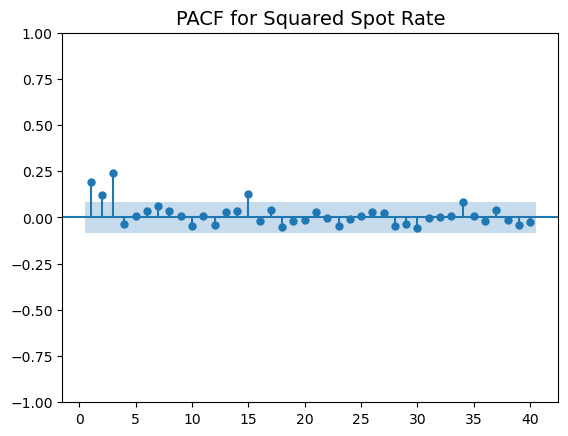

In [33]:
sgt.plot_pacf(data.sqspot[1:],lags=40,zero=False,method='ols')
plt.title("PACF for Squared Spot Rate", size=14)

In [34]:
#pip install arch

In [35]:
from arch import arch_model

 I decided directly use AR-ARCH model with the lags of [3,2] on spot_change with p=4 (Based on PACF)

In [38]:
model_ar_arch=arch_model(data.sp_change[1:], mean='AR', lags=[3,2], vol='ARCH', p=4)
results_ar_arch=model_ar_arch.fit(update_freq=4)
results_ar_arch.summary()

#Question: There is no ARMA-ARCH model 

C:\Users\mike6\anaconda3\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.481e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     54,   Neg. LLF: 3434.5449358404476
Iteration:      8,   Func. Count:    105,   Neg. LLF: 21412.90457033068
Iteration:     12,   Func. Count:    155,   Neg. LLF: 3847.368371663161
Iteration:     16,   Func. Count:    211,   Neg. LLF: 118704640808.36336
Iteration:     20,   Func. Count:    268,   Neg. LLF: 1533.4676822119532
Iteration:     24,   Func. Count:    324,   Neg. LLF: 1818.6206894439492
Iteration:     28,   Func. Count:    380,   Neg. LLF: 1162.2088332972269
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1781.518884015813
            Iterations: 33
            Function evaluations: 391
            Gradient evaluations: 29


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - ARCH Model Results                            
==============================================================================
Dep. Variable:              sp_change   R-squared:                       0.010
Mean Model:                        AR   Adj. R-squared:                  0.006
Vol Model:                       ARCH   Log-Likelihood:                1781.52
Distribution:                  Normal   AIC:                          -3547.04
Method:            Maximum Likelihood   BIC:                          -3513.04
                                        No. Observations:                  518
Date:                Mon, Nov 20 2023   Df Residuals:                      515
Time:                        12:20:41   Df Model:                            3
                                   Mean Model                                   
================================================================================
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const        -3.3738e-04  3.400e-04     -0.992      0.321 [-1.004e-03,3.290e-04]
sp_change[2]     -0.1176  4.901e-02     -2.400  1.641e-02   [ -0.214,-2.155e-02]
sp_change[3]     -0.0158  4.611e-02     -0.343      0.732    [ -0.106,7.457e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.7695e-05  3.099e-06     12.163  4.881e-34 [3.162e-05,4.377e-05]
alpha[1]       0.2066  8.796e-02      2.349  1.882e-02   [3.422e-02,  0.379]
alpha[2]       0.0800  4.927e-02      1.624      0.104  [-1.654e-02,  0.177]
alpha[3]       0.0750  8.414e-02      0.891      0.373  [-8.990e-02,  0.240]
alpha[4]       0.0750  6.336e-02      1.184      0.237  [-4.919e-02,  0.199]
============================================================================

Covariance estimator: robust
"""

**Step 5: Out of sample forecasting**
1. ARIMA(3,1,2)

In [39]:
data.head(3)

,Adj Close,sp_change,res_arima_312,sqspot
Date,,,,
2021-11-17,4.109285,NaN,4.109285,NaN
2021-11-18,4.116634,0.001788,0.007349,0.000003
2021-11-19,4.104927,-0.002844,-0.012566,0.000008


In [40]:
#Create training and testing
print(len(data.sp_change))
#There are 522 rows 

522


In [73]:
train=data['Adj Close'][:418] #80% of data
test=data['Adj Close'][418:] #20% of data

In [74]:
model_spot = ARIMA(train, order=(3,1,2))
results_spot = model_spot.fit()

C:\Users\mike6\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [75]:
results_spot.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  418
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 788.449
Date:                Mon, 20 Nov 2023   AIC                          -1564.897
Time:                        13:14:39   BIC                          -1540.699
Sample:                    11-17-2021   HQIC                         -1555.330
                         - 06-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6121      0.205      2.991      0.003       0.211       1.013
ar.L2         -0.8093      0.155     -5.233      0.000      -1.112      -0.506
ar.L3          0.1500      0.061      2.467      0.014       0.031       0.269
ma.L1         -0.4703      0.200     -2.346      0.019      -0.863      -0.077
ma.L2          0.6274      0.166      3.770      0.000       0.301       0.954
sigma2         0.0013    7.2e-05     18.519      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                87.87
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
fc = results_spot.get_forecast(steps=100, alpha=0.05).summary_frame()

In [80]:
fc.head()

Adj Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-06-26,4.042716,0.036518,3.971142,4.114291
2023-06-27,4.045095,0.055425,3.936464,4.153725
2023-06-28,4.040308,0.067323,3.908357,4.172258
2023-06-29,4.036718,0.077003,3.885796,4.187640
2023-06-30,4.038752,0.086983,3.868269,4.209235


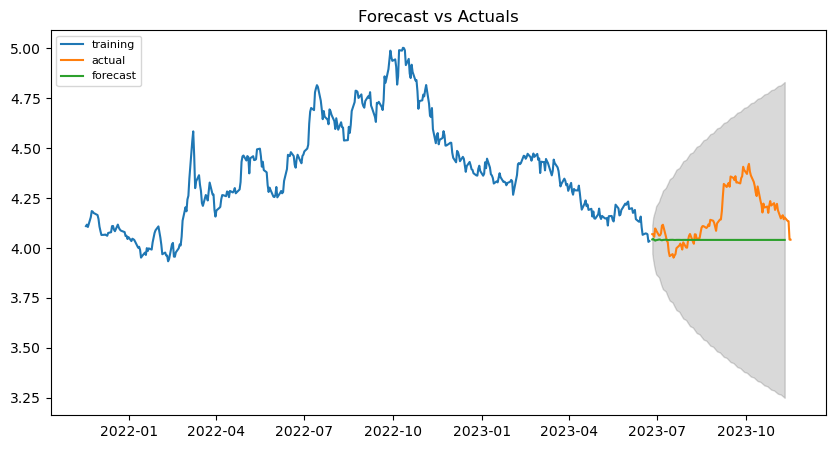

In [81]:
plt.figure(figsize=(10,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc['mean'], label='forecast')
plt.fill_between(fc.index, fc.mean_ci_lower, fc.mean_ci_upper, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

For ARCH: AR(3,2), p=4

In [90]:
model_spot_ARCH32_p4=arch_model(train, mean='AR', lags=[3,2], vol='ARCH', p=4)
results_spot_ARCH32_p4 = model_spot_ARCH32_p4.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 16964954878.989813
Iteration:      2,   Func. Count:     27,   Neg. LLF: 78036.8771337016
Iteration:      3,   Func. Count:     39,   Neg. LLF: 12822429.381940287
Iteration:      4,   Func. Count:     50,   Neg. LLF: 19520.289375307504
Iteration:      5,   Func. Count:     60,   Neg. LLF: 255382.59813322104
Iteration:      6,   Func. Count:     70,   Neg. LLF: -435.8995259413885
Iteration:      7,   Func. Count:     80,   Neg. LLF: -550.02764502074
Iteration:      8,   Func. Count:     90,   Neg. LLF: -648.7009237425782
Iteration:      9,   Func. Count:    100,   Neg. LLF: -614.0679065821373
Iteration:     10,   Func. Count:    110,   Neg. LLF: -642.2376037981987
Iteration:     11,   Func. Count:    120,   Neg. LLF: -666.2417726871818
Iteration:     12,   Func. Count:    129,   Neg. LLF: -655.3593169180126
Iteration:     13,   Func. Count:    139,   Neg. LLF: -562.0438731898585
Iteration:     14,   Func. Count:    149,   Neg. LLF: -

C:\Users\mike6\anaconda3\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [91]:
results_spot_ARCH32_p4

                           AR - ARCH Model Results                            
Dep. Variable:              Adj Close   R-squared:                       0.947
Mean Model:                        AR   Adj. R-squared:                  0.947
Vol Model:                       ARCH   Log-Likelihood:                667.269
Distribution:                  Normal   AIC:                          -1318.54
Method:            Maximum Likelihood   BIC:                          -1286.31
                                        No. Observations:                  415
Date:                Mon, Nov 20 2023   Df Residuals:                      412
Time:                        13:19:09   Df Model:                            3
                                  Mean Model                                 
                   coef    std err          t      P>|t|     95.0% Conf. Int.
-----------------------------------------------------------------------------
Const            0.1011  6.974e-02      1.450      0.14

In [93]:
forecasts = results_spot_ARCH32_p4.forecast(horizon=30,reindex=False)
forecasts.variance.dropna().head()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-23,0.00196,0.002372,0.003668,0.00435,0.005254,0.006084,0.006904,0.007742,0.008549,0.009361,...,0.017432,0.018088,0.018731,0.01936,0.019977,0.020581,0.021173,0.021753,0.02232,0.022876


The results showed that the forecast did not show much about the randomness.
My questions are:
1. Do the forecast of an ARIMA model accounts for the distribution of the historical data?
2. How to reduce the confidence interval?
